In [1]:
# Load in the different trackers
import pandas as pd
import pickle

path_to_diff_tracker_data = "/share/D3/data/hweiner/Tracker_Comparison/CoCoMET_out"

WRF_tracks_2d_tobac = pd.read_csv(f"{path_to_diff_tracker_data}/WRF_Tracks_tobac.csv")
WRF_tracks_2d_tams = pd.read_csv(f"{path_to_diff_tracker_data}/WRF_Tracks_tams.csv")
WRF_tracks_2d_moaap = pd.read_csv(f"{path_to_diff_tracker_data}/WRF_Tracks_moaap.csv")


with open(f'{path_to_diff_tracker_data}/WRF_segmentation_2d_tobac.pickle', 'rb') as data:
    WRF_segmentation_2d_tobac = pickle.load(data)
with open(f'{path_to_diff_tracker_data}/WRF_segmentation_2d_tams.pickle', 'rb') as data:
    WRF_segmentation_2d_tams = pickle.load(data)
with open(f'{path_to_diff_tracker_data}/WRF_segmentation_2d_moaap.pickle', 'rb') as data:
    WRF_segmentation_2d_moaap = pickle.load(data)

/tmp/ipykernel_1890942/1226916631.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)
/tmp/ipykernel_1890942/1226916631.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
/tmp/ipykernel_1890942/1226916631.py:148: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
/tmp/ipykernel_1890942/1226916631.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)
/tmp/ipykernel_1890942/1226916631.py:148: UserWarning: set_ticklabels() should only be used with

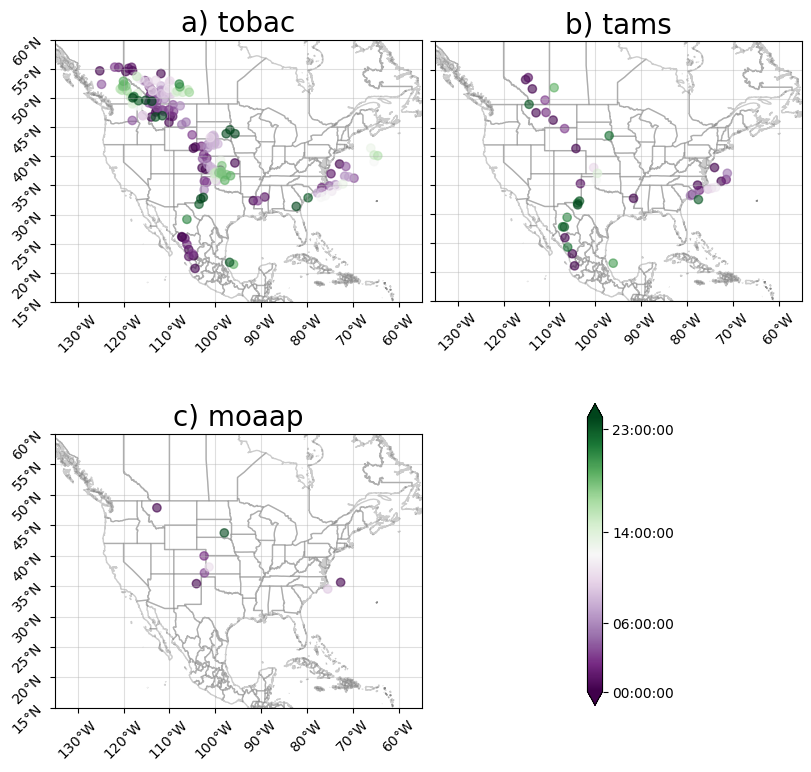

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import datetime

def plot_cell_initial_times_multiple_plots(
    tracks : list[pd.DataFrame], 
    dataset_name : list[str], 
    tracker_name : list[str], 
    specify_bounds : list[tuple, tuple] | None = None,
    save: str | None = None
) -> None:
    """
    
    Inputs
    ------
        tracks : list[pd.DataFrame]
            A dataframe of the tracks information
        dataset_name : list[str]
            A string of the name of the dataset to put in the plot title
        tracker_name : list[str]
            A string of the name of the tracker to put in the plot title
        specify_bounds : list[tuple, tuple] | None = None
            A list of tuples containing (min_lon, max_lon) and (min_lat, max_lat) or None. If None, will automatically size plot. The default is None
        save: str | None = None
            The path to save the plot to or None. If None the plot will not be saved. The default is None
    
    Returns
    -------
        None
    """
    
    # Create the figure
    fig, axes = plt.subplots(2, 2, figsize=[8, 8], sharey=True, layout="constrained")

    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    alphabet = alphabet[:len(tracks)]

    # Iterate through each tracks
    for ind, track, ds_name, tkr_name, bounds, let in zip(range(len(tracks)), tracks, dataset_name, tracker_name, 
                                                    specify_bounds, alphabet):
        row = ind // 2
        col = ind - row * 2
        ax = axes[row, col]

        cell_groups = track.groupby("cell_id")
        initial_time_dict = {"cell_id" : [], "datetime_time" : [], "lat" : [], "lon" : [], "frame" : []}

        # Iterate through the cell groups
        for cell_id, cellg in cell_groups:
            
            # TODO : some entries are nan, instead of using a row, use the minimum frame value to set the column
            start_row = cellg.iloc[0]
            start_frame = start_row["frame"]
            lat = start_row["latitude"]
            lon = start_row["longitude"]
            datetime_time = start_row["time"]

            # Check to make sure the row we choose is at the start of the cell's lifetime
            if start_row["lifetime"] != 0:
                if np.isnan(start_row["lifetime"]):
                    continue
                else:
                    raise ValueError("This is not the cells initial time")

            # Add data to the dictionary
            initial_time_dict["cell_id"].append(cell_id)
            initial_time_dict["frame"].append(start_frame)
            initial_time_dict["lat"].append(lat)
            initial_time_dict["lon"].append(lon)
            initial_time_dict["datetime_time"].append(datetime_time)

        # Add the geometry and make a geodataframe
        crs = "EPSG:4326"
        geometry = gpd.points_from_xy(initial_time_dict["lon"], initial_time_dict["lat"])
        init_time_df = gpd.GeoDataFrame(initial_time_dict, crs = crs, geometry=geometry)

        # Plot country/state borders to make the plot look nice
        url = "/share/D3/data/hweiner/ne_10m_admin_1_states_provinces.zip"
        world = gpd.read_file(url)
        world.plot(ax=ax, edgecolor='grey', facecolor='none', alpha=0.4)

        # Derive the minimum and maximum plot bounds
        minx = np.min(init_time_df['geometry'].bounds['minx'])
        miny = np.min(init_time_df['geometry'].bounds['miny'])
        maxx = np.max(init_time_df['geometry'].bounds['maxx'])
        maxy = np.max(init_time_df['geometry'].bounds['maxy'])

        # If there are set bounds then use those
        if bounds is not None:
            ax.set_xlim(*bounds[0])
            ax.set_ylim(*bounds[1])
        else:
            ax.set_xlim(minx * 1.005, maxx * 0.995)
            ax.set_ylim(miny * 0.995, maxy * 1.005)

        # Find the times for the legend labels
        if type(init_time_df["datetime_time"][0]) == str:
            full_date_labels = np.unique([datetime.datetime.strptime(i.split(".")[0], "%Y-%m-%d %H:%M:%S") for i in init_time_df["datetime_time"]])
            labels = np.unique([datetime.datetime.strftime(i, "%H:%M:%S") for i in full_date_labels])

        else:
            labels = np.unique([datetime.datetime.strftime(i, "%H:%M:%S") for i in init_time_df["datetime_time"]])

        legend_tick_spacer = int(np.floor(len(labels) / 3))

        # Use the second subplots legend (it doesn't matter which subplot's legend you use)
        if ind == 1:
            # plot twice, then erase the last subplot so that only the legend remains
            init_time_df.plot(ax=axes[1, 1], column="frame", legend=True, cmap="PRGn", marker='o', alpha=0.6, 
                                legend_kwds={"format": mticker.FixedFormatter(labels[::legend_tick_spacer]), "orientation": "vertical", 
                                "shrink": 0.8, "pad": -0.6, "extend": "both", "ticks": np.unique(init_time_df["frame"])[::legend_tick_spacer]})
            axes[1, 1].clear()
            axes[1,1].axis("off")
            axes[1,1].set_visible(False)
            axes[1,1].remove()
            
            init_time_df.plot(ax=ax, column="frame", legend=False, cmap="PRGn", marker='o', alpha=0.6,)

        else:
            init_time_df.plot(ax=ax, column="frame", legend=False, cmap="PRGn", marker='o', alpha=0.6,)

        ax.grid(alpha=0.4)

        if tracker_name is not None:
            ax.set_title(f"{let}) {tkr_name}", fontsize=20)
        else:
            ax.set_title(f"{let}) {ds_name} Initial Cell Times", fontsize=20)

        # Since we are sharing a y axis, you only need to put axis labels on plots 0 and 2. Use the first plots ylabels
        if ind == 0 or ind == 2:
            ytl = axes[0, 0].get_yticklabels()
            new_ytl = []

            for ctl_y in ytl:
                ty = ctl_y.get_text()
                new_ytl.append(fr'{ty}$\degree$N')

            ax.set_yticklabels(new_ytl, rotation=45, fontsize=10)

        xtl = ax.get_xticklabels()
        new_xtl = []
        for ctl_x in xtl:
            tx = ctl_x.get_text()
            new_xtl.append(fr'{tx[1:]}$\degree$W')

        ax.set_xticklabels(new_xtl, rotation=45, fontsize=10)
        
    if save != None:
        plt.savefig("/D3/data/hweiner/tracker_init_times.png", dpi = 600)

    plt.show()

# plot_cell_initial_times(WRF_tracks_2d_tams, dataset_name="CONUS", tracker_name="TAMS", specify_bounds=bounds)
bounds = [(-135, -55), (15, 60)]

tracks_list = [WRF_tracks_2d_tobac, WRF_tracks_2d_tams, WRF_tracks_2d_moaap]
tams_ax = plot_cell_initial_times_multiple_plots(tracks_list, dataset_name=["CONUS", "CONUS", "CONUS"], 
                                                tracker_name=["tobac", "tams", "moaap"], specify_bounds=[bounds] * len(tracks_list), save = None)